# How to hit my API

To hit my endpoint, just tell it which cells you've already tried, and which are hits and which were misses.
Additionally, tell it how many squids the game interface has told you that you've already completely gotten.

In [145]:
from __future__ import print_function
import requests
import numpy as np
import matplotlib.pyplot as plt

response = requests.post(
    "http://ec2-34-223-48-61.us-west-2.compute.amazonaws.com:1234/sk",
    json={
        # Cells we've already tried and hit.
        "hits": [(4, 4)],
        # Cells we've already tried and missed.
        "misses": [(3, 3), (3, 2), (3, 4), (5, 5), (7, 7)],
        # Squids we've already gotten.
        "squids_gotten": 0,
    },
)
print(response.json())

{u'probabilities': [[0.060645336709802454, 0.09053182512999641, 0.11283682523532473, 0.10350328941217117, 0.1155941074132279, 0.11248507162886356, 0.09031447512402138, 0.06052794031418309], [0.09054862965867914, 0.1200728998409064, 0.1417878894109371, 0.09838519052380096, 0.21788813249825803, 0.1354130921967604, 0.11626045234112597, 0.09028212285321251], [0.10250232887529791, 0.11142360112684524, 0.10505891552373761, 0.0, 0.33544485862352846, 0.11166394441806417, 0.12237779189275733, 0.10948546410632173], [0.11415081654399122, 0.12270810041781884, 0.11659400169889055, 0.0, 0.5573360398173911, 0.09296719018996004, 0.12410050072513386, 0.11628577442147912], [0.11390199021096865, 0.12204081638786216, 0.11557398062470461, 0.0, 1.0, 0.2783948978492565, 0.2761045076683967, 0.19009995090492526], [0.11216245511278808, 0.13699839095209532, 0.1453789455179896, 0.06889104293862662, 0.5448441373719176, 0.0, 0.08237972556948377, 0.06738540597806046], [0.09019533863069447, 0.11748776882102709, 0.135

 Make sure to double check the `is_possible` field! The `probabilities` field will give a list of length 8 of lists of length 8 giving probabilities of finding any squid part in each of the 64 cells. These probabilities are exact -- they're NOT approximated nor estimated via Monte Carlo methods. It's just a direct computation of:

$$ P(\text{squid)\ |\ \text{observation}) = \frac{P(\text{squid)\ \cap\ \text{observation})}{P(\text{observation})} $$
 
 

In [149]:
def show_payload(payload):
    response = requests.post(
        "http://ec2-34-223-48-61.us-west-2.compute.amazonaws.com:1234/sk",
        json=payload,
    ).json()
    if not response["is_possible"]:
        print("Impossible conditions!")
        return
    plt.matshow(response["probabilities"])

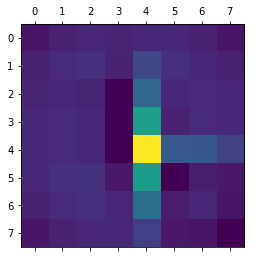

In [150]:
show_payload({
    "hits": [(4, 4)],
    "misses": [(3, 3), (3, 2), (3, 4), (5, 5), (7, 7)],
    "squids_gotten": 0,
})

In [151]:
show_payload({
    "hits": [(4, 4)],
    "misses": [(3, 3), (3, 2), (3, 4), (5, 5), (7, 7)],
    "squids_gotten": 1,
})

Impossible conditions!


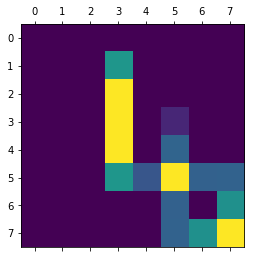

In [152]:
show_payload({
    "hits": [(3, 3), (3, 2), (3, 4), (5, 5), (7, 7)],
    "misses": [(4, 4)],
    "squids_gotten": 0,
})

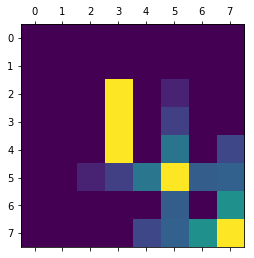

In [153]:
show_payload({
    "hits": [(3, 3), (3, 2), (3, 4), (5, 5), (7, 7)],
    "misses": [(4, 4)],
    "squids_gotten": 1,
})

# How to calculate it yourself
(But without the squid logic, although that's an easy enough addition.

In [1]:
import itertools, struct

valid_cells = [
    (i, j)
    for i in range(8)
    for j in range(8)
]
valid_cells_set = set(valid_cells)

# This includes some impossible origins, but it doesn't matter because we filter down later.
squid_origins = [
    (squid_top_left, squid_direction)
    for squid_top_left in valid_cells
    for squid_direction in (False, True)
]

def squid_spot(squid_desc, offset):
    (x, y), direction = squid_desc
    return (x + offset, y) if direction else (x, y + offset)

def _find_all_configs(masks, inverse_weights, taken_so_far, remaining_lengths, denom):
    if len(remaining_lengths) == 0:
        masks.append(taken_so_far)
        inverse_weights.append(denom)
        return

    squid_len = remaining_lengths[0]
    good_descs = []
    for squid_desc in squid_origins:
        for offset in range(squid_len):
            new_spot = squid_spot(squid_desc, offset)
            if new_spot in taken_so_far or new_spot not in valid_cells_set:
                break
        else:
            good_descs.append(squid_desc)

    for squid_desc in good_descs:
        t = taken_so_far.copy()
        for offset in range(squid_len):
            t.add(squid_spot(squid_desc, offset))
        _find_all_configs(masks, inverse_weights, t, remaining_lengths[1:], denom * len(good_descs))

    return find_all_configs

def find_all_configs(lengths):
    masks = []
    inverse_weights = []
    _find_all_configs(masks, inverse_weights, set(), lengths, 1)
    return masks, inverse_weights

masks,    inverse_weights    = find_all_configs([2, 3, 4])
# These are NOT the correct weights, but compute them for fun.
#masks432, inverse_weights432 = find_all_configs([4, 3, 2])
print("Length:", len(masks))
print("Probs:", set(inverse_weights))

total_prob = 0
for w in inverse_weights:
    total_prob += 1.0 / w
print("Total prob:", total_prob)

Length: 604584
Probs: set([659456, 630784, 581504, 520128, 633360, 510496, 675360, 623616, 500864, 642096, 591360, 545664, 598080, 631904, 643104, 710976, 578144, 627984, 601216, 680064, 682864, 621712, 611072, 635040, 535920, 687792, 685440, 607936, 611520, 618016, 655200, 645120, 522368, 690368, 506688, 667856, 620928, 604800, 695520, 662480, 564480, 647920, 532224, 700672, 638848, 703248, 594720, 652848, 558208, 608048, 542080, 640640, 628544, 657888, 677824, 693056, 616448, 669760, 516432, 614880, 606816, 713440, 526176, 551936, 574560, 597184, 650496, 568176, 624960, 618240, 587552, 721280, 705600, 555408, 577920, 561792, 672672, 601328, 660352, 568288, 652288, 574896, 558656, 665280, 649152, 626080, 565152, 549024, 571648, 594384, 670208, 539392, 604128, 588112, 584640, 637952, 591136, 613872, 529760])
Total prob: 1.0


In [ ]:
# Write out files.


In [23]:
len(masks)

604584

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
probabs    = np.array([1.0 / w for w in inverse_weights])
#probabs432 = np.array([1.0 / w for w in inverse_weights432])

In [19]:
print("Maximum bias:", max(probabs) / min(probabs))

Maximum bias: 1.4400715563506261


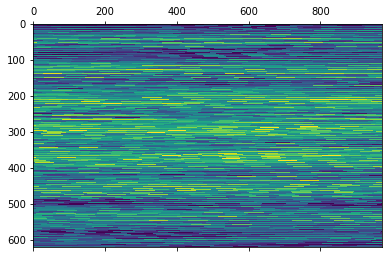

In [4]:
plt.matshow(probabs.reshape((622, 972)))
#plt.matshow(probabs432.reshape((622, 972)))

In [5]:
# We now build a matrix.
presence_matrix = np.array([[cell in mask for cell in valid_cells] for mask in masks], dtype=np.int8)
probab_weighted_presence_matrix = presence_matrix * probabs.reshape((-1, 1))

In [142]:
import json
with open("/tmp/data.json", "w") as f:
    s = json.dumps({
        "presence_matrix": presence_matrix.tolist(),
        "weights": probabs.tolist(),
    }).replace(" ", "")
    f.write(s)
    f.write("\n")

In [34]:
presence_matrix.shape

(604584, 64)

In [16]:
cell_to_index = {cell: i for i, cell in enumerate(valid_cells)}

def compute_probabilities(hits, misses):
    # This is a simple Bayes update.
    #   P(cell contains squid | observation) =
    #       P(cell contains squid AND observation) / P(observation)
    # Note that P(cell contains squid AND observation) is just P(cell contains squid)
    # if the observation is compatible
    # Start with a mask saying every possible board is admissible.
    mask = np.array([True] * presence_matrix.shape[0], np.bool)
    # Filter out all the boards that are incompatible with a hit we've seen so far.
    for hit in hits:
        mask &= presence_matrix[:, cell_to_index[hit]] == 1
    # Filter out all the boards that are incompatible with a miss we've seen so far.
    for miss in misses:
        mask &= presence_matrix[:, cell_to_index[miss]] == 0
    # Compute the total probability of every board layout compatible with our observation.
    # This is simply P(observation).
    observation_probability = probabs[mask].sum()
    # Marginalize the distribution, and renormalize by the 
    return probab_weighted_presence_matrix[mask].sum(axis=0) / observation_probability

def make_greedy_move(hits, misses):
    weights = compute_probabilities(hits, misses)
    for cell in hits + misses:
        weights[cell_to_index[cell]] = -1
    return valid_cells[np.argmax(weights)]

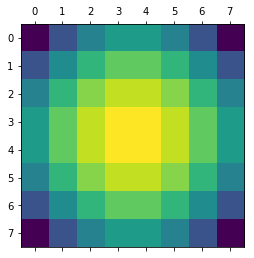

In [7]:
plt.matshow(probab_weighted_presence_matrix.sum(axis=0).reshape(8, 8))

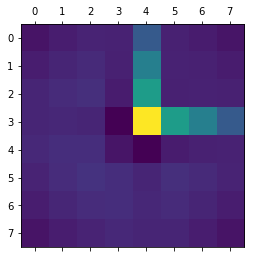

In [20]:
plt.matshow(compute_probabilities(hits=[(3, 4)], misses=[(3, 3), (4, 4)]).reshape(8, 8))

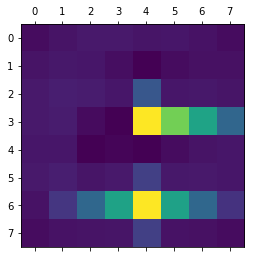

In [33]:
plt.matshow(compute_probabilities(
    hits=[(3, 4), (6, 4)],
    misses=[(3, 3), (4, 4), (1, 4), (4, 2)],
).reshape(8, 8))

In [18]:
make_greedy_move([(3, 4)], [(3, 3), (4, 4)])

(2, 4)

In [40]:
import random
def make_board():
    board = set()
    def place(squid_len):
        while True:
            desc = random.choice(squid_origins)
            for offset in range(squid_len):
                spot = squid_spot(desc, offset)
                if spot in board or spot not in valid_cells_set:
                    break
            else:
                break
        for offset in range(squid_len):
            board.add(squid_spot(desc, offset))
    place(2)
    place(3)
    place(4)
    return board

In [44]:
make_board()

{(1, 7), (2, 7), (3, 4), (4, 4), (4, 7), (5, 4), (5, 7), (6, 7), (7, 7)}

In [50]:
make_board()

{(1, 1), (1, 6), (2, 1), (2, 6), (3, 1), (3, 4), (3, 6), (4, 4), (4, 6)}

In [136]:
def play(board):
    hits, misses = [], []
    while len(hits) < 9:
        m = make_greedy_move(hits, misses)
        #print("Hitting:", m)
        if m in board:
            hits.append(m)
        else:
            misses.append(m)
    return len(hits) + len(misses)

In [54]:
def show_board(b):
    r = np.zeros((8, 8))
    for xy in b:
        r[xy] = 1
    plt.matshow(r)

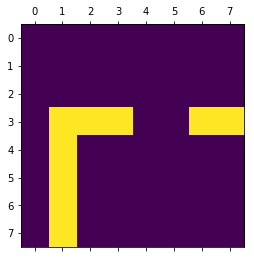

In [67]:
show_board(make_board())

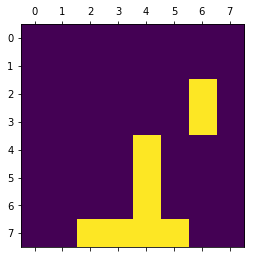

In [106]:
b = make_board()
show_board(b)
hits, misses = [], []

Hitting: (0, 3) Shots so far: 27


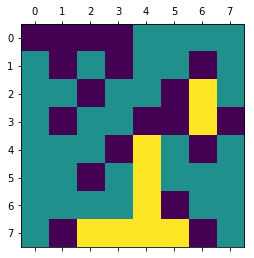

In [135]:
m = make_greedy_move(hits, misses)
print("Hitting:", m, "Shots so far:", len(hits + misses))
if m in b:
    hits.append(m)
else:
    misses.append(m)
r = np.zeros((8, 8))
for xy in hits:
    r[xy] = 1
for xy in misses:
    r[xy] = -1
plt.matshow(r)

In [138]:
values = []
while True:
    count = play(make_board())
    values.append(count)
    print(count)
    print("Wins percentage: ", (np.array(values) <= 20).mean())

36
Wins percentage:  0.0
27
Wins percentage:  0.0
36
Wins percentage:  0.0
24
Wins percentage:  0.0
29
Wins percentage:  0.0
39
Wins percentage:  0.0
39
Wins percentage:  0.0
26
Wins percentage:  0.0
32
Wins percentage:  0.0
14
Wins percentage:  0.1
27
Wins percentage:  0.09090909090909091
22
Wins percentage:  0.08333333333333333
25
Wins percentage:  0.07692307692307693
40
Wins percentage:  0.07142857142857142
26
Wins percentage:  0.06666666666666667
23
Wins percentage:  0.0625
21
Wins percentage:  0.058823529411764705
25
Wins percentage:  0.05555555555555555
28
Wins percentage:  0.05263157894736842
18
Wins percentage:  0.1
35
Wins percentage:  0.09523809523809523
32
Wins percentage:  0.09090909090909091
28
Wins percentage:  0.08695652173913043
29
Wins percentage:  0.08333333333333333
35
Wins percentage:  0.08
39
Wins percentage:  0.07692307692307693
30
Wins percentage:  0.07407407407407407
21
Wins percentage:  0.07142857142857142
34
Wins percentage:  0.06896551724137931
24
Wins percen

KeyboardInterrupt: 